<a href="https://colab.research.google.com/github/mrbarron3/fwe458/blob/main/Homework6/Homework6_Barron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# imports
import urllib.request
import xarray as xr
import numpy as np
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt

!pip install cartopy geoviews hvplot
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [69]:
# Download the data
url = f"https://downloads.psl.noaa.gov/Datasets/ghcncams/air.mon.mean.nc"
savename = url.split("/")[-1]
urllib.request.urlretrieve(url, savename)

('air.mon.mean.nc', <http.client.HTTPMessage at 0x7996a1f5f650>)

In [70]:
# open the dataset
ds = xr.open_dataset(savename)

# convert air temperatures to celsius
data = ds.air - 273.15

In [71]:
# select dates from 1990 to 2020
ta_1990_2020 = data.sel(time=slice("1990-01-01", "2020-12-31"))

# calculate the annual mean of temperatures (not-weighted)
unweighted_2 = ta_1990_2020.mean(("lon", "lat"))
unweighted_3 = ta_1990_2020.mean(dim = "time")

# calculate the annual mean of temperatures (weighted)
# create the weights
weights = np.cos(np.deg2rad(ta_1990_2020.lat))
weights.name = "weights"

# calculate the weighted mean
ta_annual_weighted = ta_1990_2020.weighted(weights)
weighted_2 = ta_annual_weighted.mean(("lon", "lat"))
weighted_3 = ta_annual_weighted.mean(dim = "time")
# code adapted from https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html

In [72]:
# *** attempts at adding trend lines
# define a function to compute a linear trend of a time series (we use numpy.polyfit())
def linear_trend(y):
    if np.isnan(y).any():
        return np.nan
    x = np.arange(len(y))
    pf = np.polyfit(x, y, 1)
    # need to return an xr.DataArray for groupby
    return pf[0]

# get the mean across all the years
ta_annual = ta_1990_2020.resample(time = "31Y").mean()

trend_results = xr.apply_ufunc(
    linear_trend,  # func name
    ta_annual,   # data
    input_core_dims = [["time"]],   # Specifies the core dimensions of the input data (in this case, "time" is the core dimension)
    vectorize = True)   # Vectorize the function (apply element-wise operations)

trend_results

/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


<xarray.DataArray 'air' (lat: 360, lon: 720)> Size: 2MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8

/usr/local/lib/python3.11/dist-packages/xarray/groupers.py:487: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


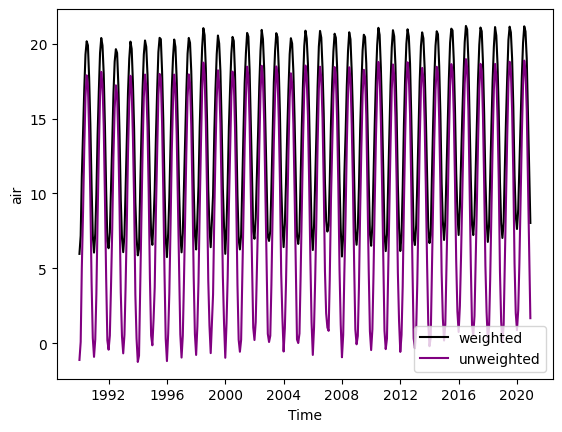

In [73]:
# ***more attempts at adding trend lines
# get the coeffs
coeffs = ta_1990_2020.polyfit(dim='time', deg=1)
# find the slope and intercept
slope = coeffs.sel(degree=1).values
intercept = coeffs.sel(degree=0).values
# coeffs_array = xr.DataArray([intercept, slope], dims=["degree"], coords={"degree": [0, 1]})
# find the trendline
# trendline = xr.polyval(ta_1990_2020['time'], coeffs_array)

# define the x and y to be graphed
# x = np.linspace(1990, 2020, 100)
# y = slope*x + intercept

# graph the unweighted trend line (i would do the same thing for unweighted if this worked)
# plt.plot(x, y)




# plot without trend lines
u_mean = ta_1990_2020.resample(time = "31Y").mean(("lon", "lat"))

# plot the weighted time series in black
weighted_2.plot(label="weighted", c = "k")

# plot the unweighted time series in purple
unweighted_2.plot(label="unweighted", c = "purple")

# show the legend
plt.legend()

plt.show()

Text(0.5, 1.0, 'Weighted Air Temperature Mean')

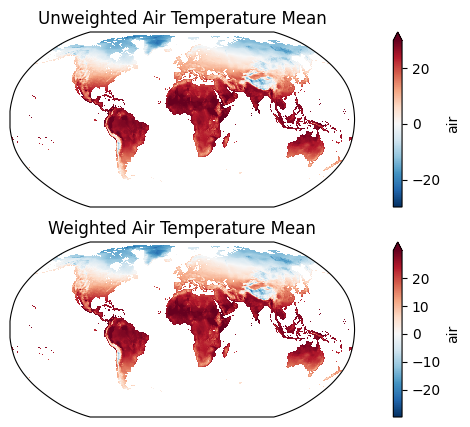

In [74]:
# make the figures with Robinson projection
fig, axes = plt.subplots(2, 1, figsize = (10, 5), subplot_kw=dict(projection=ccrs.Robinson()))

# plot the unweighted mean
unweighted_3.plot(
    ax = axes[0],
    transform=ccrs.PlateCarree(),
    robust=True,
)
# set the unweighted title
axes[0].set_title("Unweighted Air Temperature Mean")

# plot the weighted mean
weighted_3.plot(
    ax = axes[1],
    transform=ccrs.PlateCarree(),
    robust=True,
)
# set the weighted title
axes[1].set_title("Weighted Air Temperature Mean")